# Collaboration and Competition


This notebook presents the work of training two Reinforcement Learning (RL) agents to control rackets to bounce a ball over a net, in the Unity ML-Agents environment. The model that based on the Deep Deterministic Policy Gradient(DDPG) algorithm.

---
### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

---
### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


---
### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [8]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


---
### 4. Agent Architecture

Similar to the previous task where we've trained a DDPG agent to [reach target locations](https://github.com/jibin-liu/unity-ml-agent-reacher), the action space in this case is continuous as well. 

Another useful information is that, even though both of the agents in this problem are competing each other, each of them actually receives its own state. That means experiences collected from the blue racket can be shared with the red racket, and vice versa. In this case, we can have a shared replay buffer that can help both of them to learn faster.

There are many ways to work out the continuous action space, but here we're going to use the [DDPG](https://arxiv.org/abs/1509.02971) algorithm.

DDPG is an Actor-Critic style algorithm, in which there are two important components: actor and critic. Actor is a model that predict an action based on the given state, where critic is a q-value approximator that outputs the action value based on given state and action pair. The algorithm states as:

<img src="./img/ddpg_algorithm.png" width="600" />

The default hyperparameters are stored at [configuration.py](./configuration.py)

---
### 5. Train the Agent

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from ddpg_agent import Agent
from configuration import Configuration

In [10]:
def ddpg(agent, n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        local_scores = np.zeros(num_agents)
        for _ in range(max_t):
            # pick actions
            actions = agent.act(states)
            
            # take actions and observe the environments
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # update the agent
            agent.step(states, actions, rewards, next_states, dones)
            
            # update states and book-keeping
            states = next_states
            local_scores += rewards
            if np.any(dones):
                break

        local_max_score = np.max(local_scores)
        scores_deque.append(local_max_score)
        scores.append(local_max_score)

        # real-time logging
        consecutive_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'.
              format(i_episode,
                     consecutive_score,
                     local_max_score,
                     np.min(local_scores),
                     np.max(local_scores)),
              end="")
        
        # save the model every 100 episodes
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, consecutive_score))
        
        # check if problem is solved
        if consecutive_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.
                  format(i_episode, consecutive_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

/home/jibin/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.01	Score: 0.00	Min: -0.01	Max: 0.00
Episode 200	Average Score: 0.03	Score: 0.00	Min: -0.01	Max: 0.00
Episode 300	Average Score: 0.00	Score: 0.00	Min: -0.01	Max: 0.00
Episode 400	Average Score: 0.00	Score: 0.00	Min: -0.01	Max: 0.00
Episode 500	Average Score: 0.00	Score: 0.00	Min: -0.01	Max: 0.00
Episode 600	Average Score: 0.07	Score: 0.10	Min: -0.01	Max: 0.10
Episode 700	Average Score: 0.18	Score: 0.20	Min: 0.09	Max: 0.200
Episode 800	Average Score: 0.20	Score: 0.10	Min: -0.01	Max: 0.10
Episode 900	Average Score: 0.24	Score: 0.10	Min: -0.01	Max: 0.10
Episode 1000	Average Score: 0.42	Score: 0.20	Min: 0.09	Max: 0.20
Episode 1100	Average Score: 0.31	Score: 0.20	Min: 0.19	Max: 0.200
Episode 1200	Average Score: 0.38	Score: 0.00	Min: -0.01	Max: 0.00
Episode 1300	Average Score: 0.29	Score: 0.10	Min: 0.09	Max: 0.100
Episode 1400	Average Score: 0.34	Score: 0.10	Min: -0.01	Max: 0.10
Episode 1500	Average Score: 0.42	Score: 1.09	Min: 1.00	Max: 1.090
Episode 1531	Average

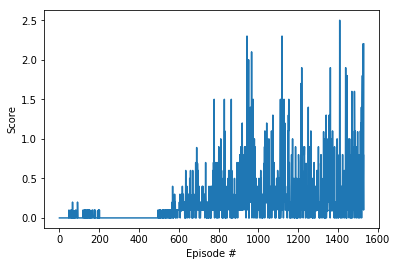

In [11]:
def train_ddpg():

    default_config = Configuration()
    agent = Agent(state_size=state_size, action_size=action_size, config=default_config)
    scores = ddpg(agent)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

train_ddpg()

In [12]:
# Close the environment
env.close()

---
### 6. Future Improvements

To improve the current algorithm and make the agent to learn faster, a few places can be tried:
- Increase the replay size and frequency
- Increse the batch size

Meanwhile, there are other algorithms that can be applied to this problem, for example:
- Use the [multi-agent DDPG (MADDPG) algorithm](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf). MADDPG is designed specifically to solve multi-agents problems, which is well-suited for this problem.
